# Step 4: Machine Learning Engineer

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Average Precision (AP) Comparison

In [11]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Carregar o dataset
sephora_data = pd.read_csv('sephora_reviews.csv')

# Combinar colunas relevantes em uma coluna de texto única, se necessário
sephora_data['combined_text'] = sephora_data['Review']  # Ajuste aqui caso tenha mais colunas

# Inicializar o modelo SBERT para gerar embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Gerar embeddings para cada texto combinado usando SBERT
embeddings_pretrained = model.encode(sephora_data['combined_text'].tolist(), convert_to_tensor=True).cpu().numpy()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
embeddings_tuned = np.load('fine_tuned_embeddings.npy')

In [17]:
import numpy as np

# Criar rótulos artificiais binários (0 e 1)
np.random.seed(42)  # Para reprodutibilidade
labels = np.random.randint(0, 2, size=len(sephora_data))


In [18]:
from sklearn.model_selection import train_test_split

# Dividir os dados em treino e teste para embeddings pré-treinados
X_train_pretrained, X_test_pretrained, y_train, y_test = train_test_split(embeddings_pretrained, labels, test_size=0.3, random_state=42)

# Dividir os dados em treino e teste para embeddings ajustados
X_train_tuned, X_test_tuned, _, _ = train_test_split(embeddings_tuned, labels, test_size=0.3, random_state=42)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

# Função para treinar e avaliar o modelo
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade para a classe positiva
    return y_pred_proba

# Função para calcular AP
def calculate_ap(y_test, y_pred_proba):
    return average_precision_score(y_test, y_pred_proba)

# Avaliação com Embeddings Pré-treinados
y_pred_proba_pretrained = train_and_evaluate(X_train_pretrained, X_test_pretrained, y_train, y_test)
ap_pretrained = calculate_ap(y_test, y_pred_proba_pretrained)
print(f"Precisão Média (AP) para Embeddings Pré-treinados: {ap_pretrained:.4f}")

# Avaliação com Embeddings Ajustados
y_pred_proba_tuned = train_and_evaluate(X_train_tuned, X_test_tuned, y_train, y_test)
ap_tuned = calculate_ap(y_test, y_pred_proba_tuned)
print(f"Precisão Média (AP) para Embeddings Ajustados: {ap_tuned:.4f}")


Precisão Média (AP) para Embeddings Pré-treinados: 0.4367
Precisão Média (AP) para Embeddings Ajustados: 0.4898


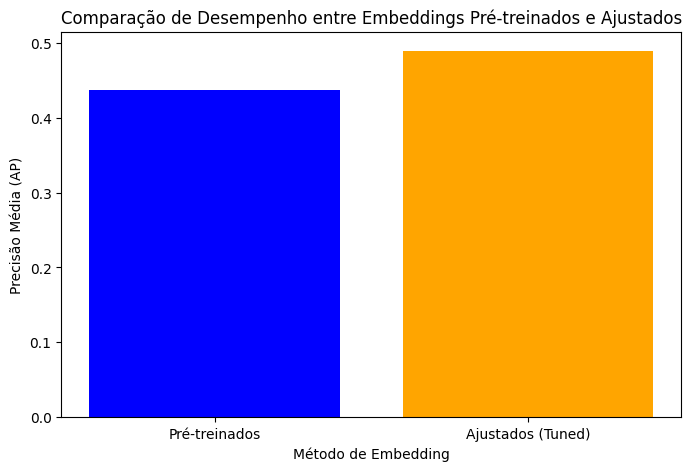

In [20]:
import matplotlib.pyplot as plt

# Resultados de AP para cada abordagem
embedding_methods = ['Pré-treinados', 'Ajustados (Tuned)']
ap_scores = [ap_pretrained, ap_tuned]

# Visualizar resultados
plt.figure(figsize=(8, 5))
plt.bar(embedding_methods, ap_scores, color=['blue', 'orange'])
plt.xlabel("Método de Embedding")
plt.ylabel("Precisão Média (AP)")
plt.title("Comparação de Desempenho entre Embeddings Pré-treinados e Ajustados")
plt.show()


# Métricas de Agrupamento

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Definir o número de clusters
num_clusters = 5

# 1. K-Means e Silhouette Score para Embeddings Pré-treinados
kmeans_pretrained = KMeans(n_clusters=num_clusters, random_state=42)
clusters_pretrained = kmeans_pretrained.fit_predict(embeddings_pretrained)
silhouette_pretrained = silhouette_score(embeddings_pretrained, clusters_pretrained)
db_score_pretrained = davies_bouldin_score(embeddings_pretrained, clusters_pretrained)

print(f"Silhouette Score para Embeddings Pré-treinados: {silhouette_pretrained:.4f}")

# 2. K-Means e Silhouette Score para Embeddings Ajustados (Tuned)
kmeans_tuned = KMeans(n_clusters=num_clusters, random_state=42)
clusters_tuned = kmeans_tuned.fit_predict(embeddings_tuned)
silhouette_tuned = silhouette_score(embeddings_tuned, clusters_tuned)
db_score_tuned = davies_bouldin_score(embeddings_tuned, clusters_tuned)

print(f"Silhouette Score para Embeddings Ajustados: {silhouette_tuned:.4f}")


Silhouette Score para Embeddings Pré-treinados: 0.0780
Silhouette Score para Embeddings Ajustados: 0.2289


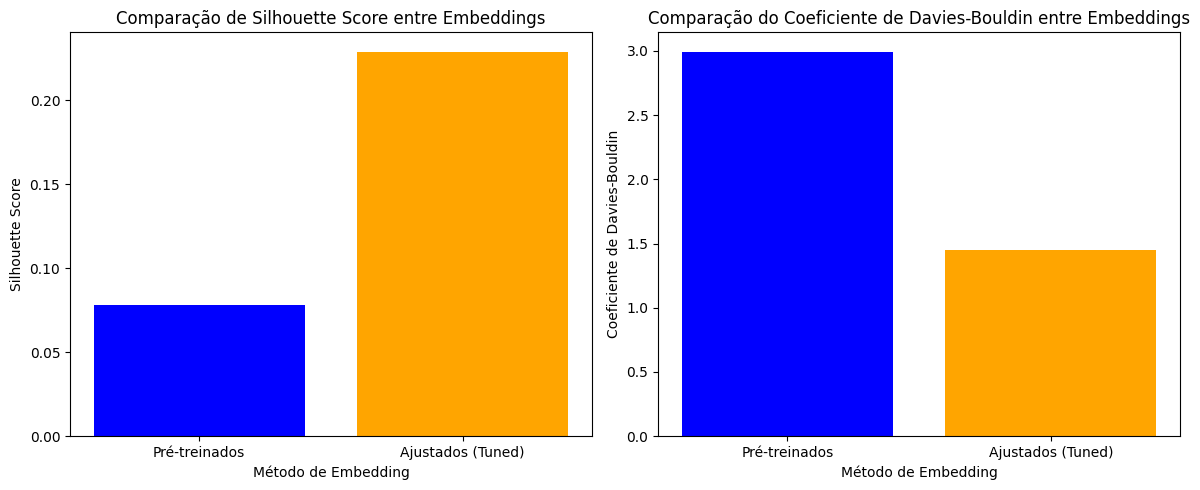

In [31]:
import matplotlib.pyplot as plt

# Dados para os gráficos com os valores calculados anteriormente
embedding_methods = ['Pré-treinados', 'Ajustados (Tuned)']
silhouette_scores = [silhouette_pretrained, silhouette_tuned]
db_scores = [db_score_pretrained, db_score_tuned]

# Configuração da figura
plt.figure(figsize=(12, 5))

# Subplot 1: Silhouette Score
plt.subplot(1, 2, 1)
plt.bar(embedding_methods, silhouette_scores, color=['blue', 'orange'])
plt.xlabel("Método de Embedding")
plt.ylabel("Silhouette Score")
plt.title("Comparação de Silhouette Score entre Embeddings")

# Subplot 2: Coeficiente de Davies-Bouldin
plt.subplot(1, 2, 2)
plt.bar(embedding_methods, db_scores, color=['blue', 'orange'])
plt.xlabel("Método de Embedding")
plt.ylabel("Coeficiente de Davies-Bouldin")
plt.title("Comparação do Coeficiente de Davies-Bouldin entre Embeddings")

# Ajustar layout e exibir gráficos
plt.tight_layout()
plt.show()
